In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score , confusion_matrix , classification_report
from Model_def import model


In [2]:

################ Load Data ################################
df = pd.read_csv("../Data/processed/processed_farming_data.csv")
df.sample(10)


,soil_pH,soil_moisture,soil_temp,nitrogen,rainfall,humidity,air_temp,wind,crop_disease_risk,crop_disease_risk_code
632,6.789673,0.562962,26.429641,70.989338,156.767149,70.074220,30.061252,10.602978,High,2
953,7.194882,0.342383,25.491403,66.686477,178.328236,87.732400,29.526487,15.924876,High,2
660,6.199028,0.399341,25.873467,64.589931,165.113317,77.781117,25.950681,20.304508,High,2
474,6.120163,0.503092,30.648914,64.447195,170.760251,87.642132,35.183892,13.591961,High,2
17,6.002426,0.335480,19.557337,56.784767,128.577154,50.258679,23.242217,10.987320,Moderate,1
204,6.293890,0.423078,26.344075,59.281862,94.400134,52.209693,26.545883,7.497155,Moderate,1
465,5.817088,0.338082,26.256961,72.963608,114.121578,62.573187,21.920892,13.690002,Moderate,1
165,6.817665,0.440587,26.861332,72.449571,159.492670,87.075918,33.534759,16.224408,High,2
874,6.383051,0.434313,29.024213,64.030064,179.860062,78.398699,31.855082,19.366801,High,2
175,7.224410,0.424793,27.396424,84.667826,160.111157,84.362357,26.427250,17.036184,High,2


In [3]:
################ Separating features and target ############
X = df.drop(columns = ["crop_disease_risk" , "crop_disease_risk_code"] , axis=1)
y = df["crop_disease_risk_code"]

In [4]:

####################### Train_Test_Split#####################
X_train , X_temp , y_train, y_temp = train_test_split(X,y , test_size = 0.2 , random_state = 42 , stratify = y)
X_test , X_val , y_test , y_val = train_test_split(X_temp,y_temp , test_size = 0.5 , random_state = 42 , stratify = y_temp)


In [5]:

#################### Standardization ##################
import pickle
scaler = StandardScaler()

X_train_scaled =scaler.fit_transform(X_train) 
X_test_scaled =scaler.transform(X_test) 
X_val_scaled =scaler.transform(X_val) 

with open("../models/scaler.pickle", "wb") as f:
    pickle.dump(scaler, f)

In [6]:

###################### Model Training #################

# model is a dictionary defined in Model_def.py .
# Thus looping over this dictionary and training the models one by one 


def train_and_evaluate(X_train_scaled, X_val_scaled, X_test_scaled,
                       y_train, y_val, y_test):

    for name, md in model.items():
        print("="*60)
        print(f"Training {name.upper()} ...")

        if name == "xgb":
            # Train with validation monitoring
            md.fit(
                X_train_scaled, y_train,
                eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
                # eval_metric="mlogloss",
                verbose=False
            )

            # Extract log loss values
            results = md.evals_result()
            train_loss = results['validation_0']['mlogloss']
            val_loss = results['validation_1']['mlogloss']

            # Plot loss curves
            plt.figure(figsize=(6,4))
            plt.plot(train_loss, label="Train LogLoss")
            plt.plot(val_loss, label="Val LogLoss")
            plt.title("XGBoost Training vs Validation Loss")
            plt.xlabel("Boosting Rounds")
            plt.ylabel("LogLoss")
            plt.legend()
            plt.show()

            # Evaluate on validation
            y_val_pred = md.predict(X_val_scaled)
            print(f"XGB Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")

        else:
            # Standard sklearn models
            md.fit(X_train_scaled, y_train)

        # Evaluate on test set (all models)
        y_test_pred = md.predict(X_test_scaled)
        print(f"{name.upper()} Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
        print(classification_report(y_test, y_test_pred))
        print("="*60, "\n")





Training LR ...
LR Test Accuracy: 0.9600
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        33
           1       0.97      0.91      0.94        33
           2       0.97      0.97      0.97        34

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100


Training SVM ...
SVM Test Accuracy: 0.9500
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        33
           1       0.97      0.88      0.92        33
           2       0.97      0.97      0.97        34

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100


Training RF ...
RF Test Accuracy: 0.9400
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        33
  

c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


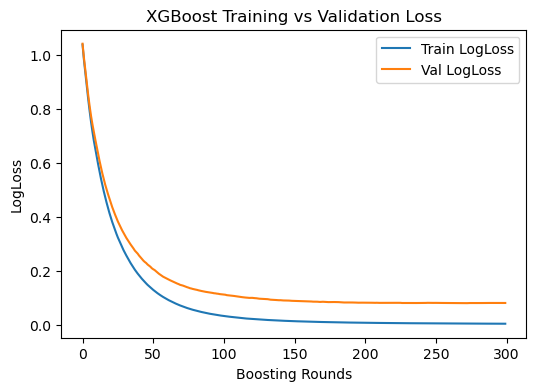

XGB Validation Accuracy: 0.9600
XGB Test Accuracy: 0.9500
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        33
           1       0.91      0.94      0.93        33
           2       0.97      0.97      0.97        34

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100




In [7]:
train_and_evaluate(X_train_scaled, X_val_scaled, X_test_scaled,
                       y_train, y_val, y_test)

In [8]:
############### Saving the best Model (XGBOOST) ##############################
import pickle

xgb_model = model["xgb"]

with open("../models/xgboost_classifier.pickle" , "wb") as f:
    pickle.dump(xgb_model , f)
    
# with open("../models/scaler.pickle", "wb") as f:
#     pickle.dump(scaler, f)